#### Exploratory Data Analysis (EDA) on COPOM Minutes

This notebook is for performing exploratory data analysis on the processed text of the COPOM minutes.
 * The script calculates basic text metrics (word count, paragraph count, lexical diversity) for each minute.
 * It generates several plots to visualize trends over time, including the number of minutes per year, word count, paragraph count, and a word cloud of the most common terms.

In [1]:
import os
import glob
import re
from typing import Dict, Any

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

from wordcloud import WordCloud

In [ ]:
FOLDER_MINUTES_TXT = "./data/processed/copom_minutes_txt" 
INITIAL_DATE = "2003-06-26"

In [3]:
minutes_info = pd.read_excel("./data/raw/minutes_info.xlsx")
minutes_info['DataReferencia'] = pd.to_datetime(minutes_info['DataReferencia'])
minutes_info = minutes_info[minutes_info["DataReferencia"] >= INITIAL_DATE]

minutes_names = minutes_info["Titulo"].to_list()
filepaths = [f"{FOLDER_MINUTES_TXT}/{minute}.txt" for minute in minutes_names]

In [4]:
def analyze_text(text: str) -> Dict[str, Any]:
    """
    Analyzes a given text to calculate its word count, paragraph count, and lexical diversity.

    Parameters:
    - text (str): The input text to be analyzed.

    Returns:
    - Dict[str, Any]: A dictionary containing the calculated metrics.
        - "word_count" (int): The total number of words in the text.
        - "paragraph_count" (int): The number of paragraphs in the text, determined by double line breaks.
        - "lexical_diversity" (float): The ratio of unique words to the total number of words.
    """

    lower_text = text.lower()
    text_wo_punctuation = re.sub(r'[^\w\s]', '', lower_text)
    tokens = text_wo_punctuation.split()

    word_count = len(tokens)
    
    paragraphs = [p for p in text.split('\n\n') if p.strip()]
    paragraph_count = len(paragraphs)
    
    if word_count == 0:
        lexical_diversity = 0
    else:
        unique_words = len(set(tokens))
        lexical_diversity = unique_words / word_count
        
    return {
        "word_count": word_count,
        "paragraph_count": paragraph_count,
        "lexical_diversity": lexical_diversity
    }

In [5]:
all_minutes_data = []
full_corpus_text = []

for path in filepaths:
    filename = os.path.basename(path)

    # Getting date
    minutes_info_temp = minutes_info.copy()
    minutes_info_temp = minutes_info_temp[minutes_info_temp["Titulo"] == filename.replace(".txt", "")]
    date = minutes_info_temp["DataReferencia"].values[0]
    
    if date is None:
        continue
        
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read()
        full_corpus_text.append(text)
        
    metrics = analyze_text(text)
    
    all_minutes_data.append({
        "filename": filename,
        "date": date,
        **metrics
    })

In [6]:
df = pd.DataFrame(all_minutes_data)
df = df.sort_values(by='date').reset_index(drop=True)
df['year'] = df['date'].dt.year

In [7]:
print(df[['word_count', 'paragraph_count', 'lexical_diversity']].describe())

        word_count  paragraph_count  lexical_diversity
count   187.000000       187.000000         187.000000
mean   4751.572193        55.160428           0.250898
std    2685.028896        23.971218           0.052606
min    1229.000000        23.000000           0.179741
25%    2128.000000        32.000000           0.197395
50%    4372.000000        63.000000           0.250112
75%    7741.000000        77.000000           0.283519
max    9363.000000        93.000000           0.391339


In [8]:
sns.set_theme(style="whitegrid", palette="viridis")

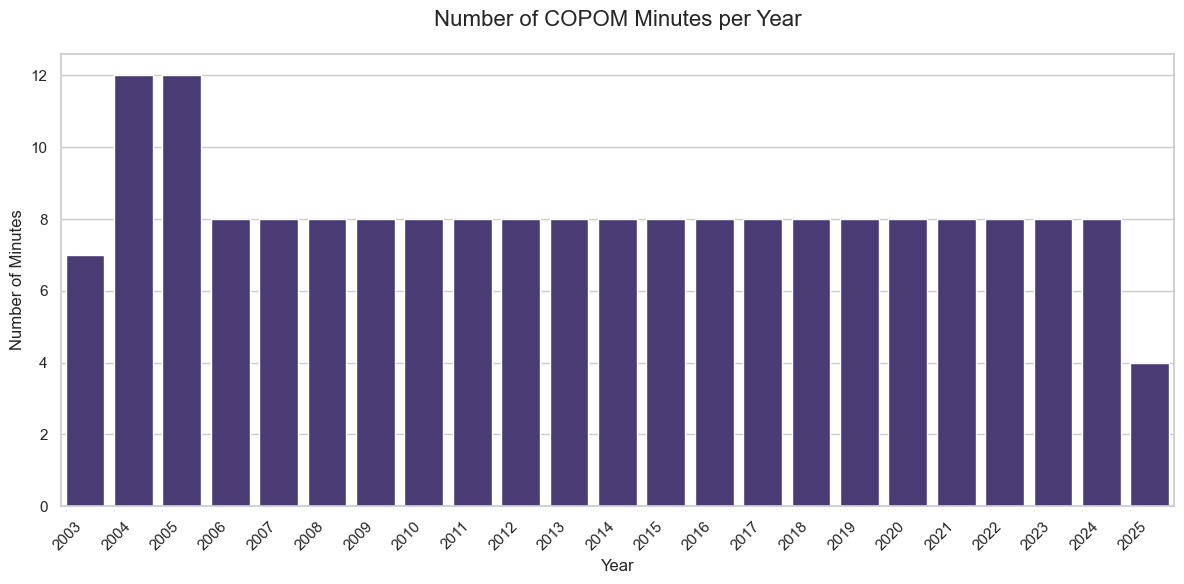

In [9]:
# 1° Graph: Number of Minutes per Year
plt.figure(figsize=(12, 6))
minutes_per_year = df.groupby('year').size()
sns.barplot(x=minutes_per_year.index, y=minutes_per_year.values)
plt.title('Number of COPOM Minutes per Year', fontsize=16, pad=20)
plt.xlabel('Year')
plt.ylabel('Number of Minutes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.close()

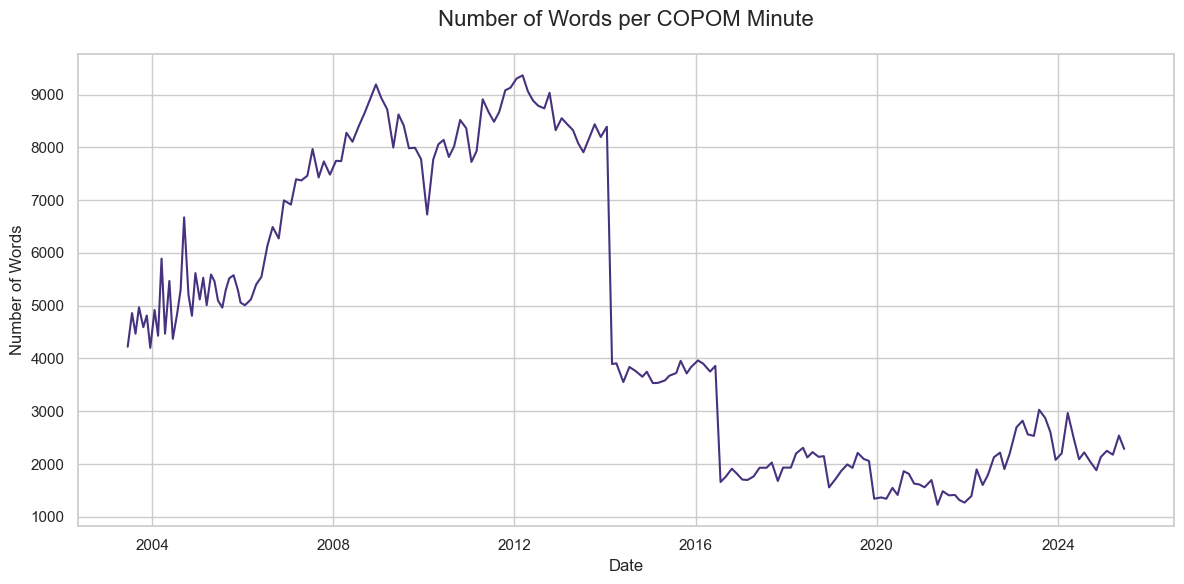

In [10]:
# 2° Graph: Number of Words per Minute
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='word_count')
plt.title('Number of Words per COPOM Minute', fontsize=16, pad=20)
plt.xlabel('Date')
plt.ylabel('Number of Words')
plt.tight_layout()
plt.show()

plt.close()

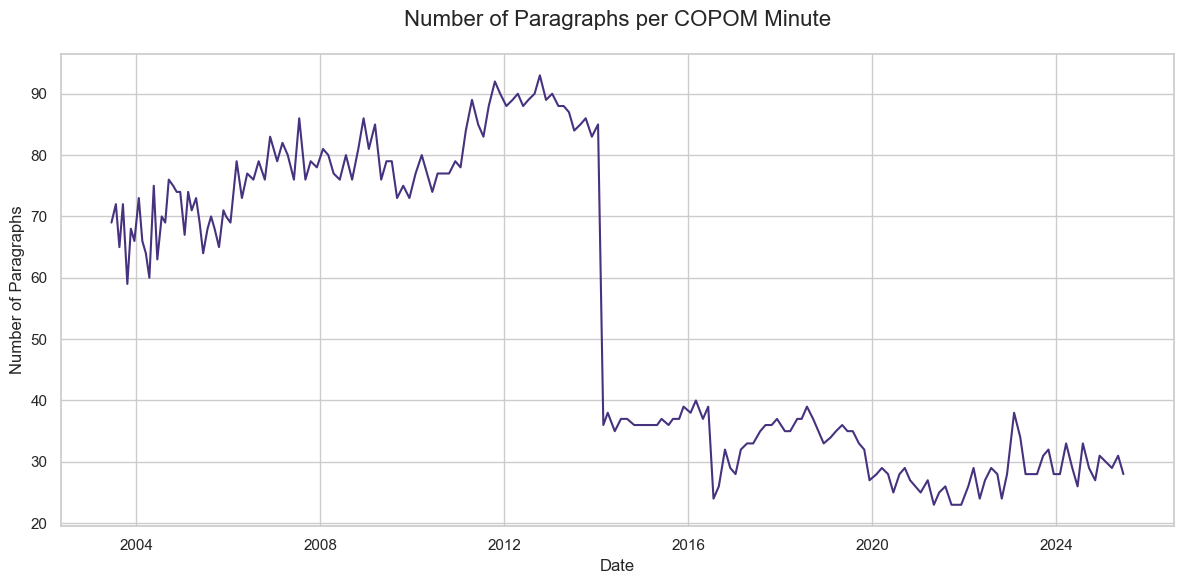

In [11]:
# 3° Graph: Number of Paragraphs per Minute
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='paragraph_count')
plt.title('Number of Paragraphs per COPOM Minute', fontsize=16, pad=20)
plt.xlabel('Date')
plt.ylabel('Number of Paragraphs')
plt.tight_layout()
plt.show()

plt.close()

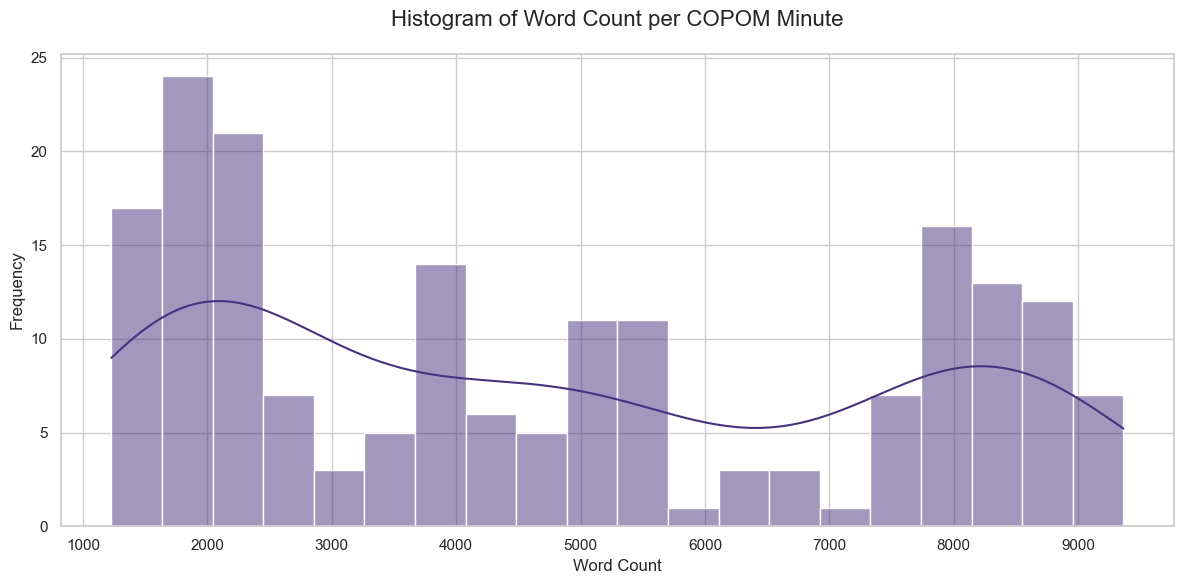

In [12]:
# 4° Graph: Histogram of Word Count per COPOM Minute
plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], kde=True, bins=20)
plt.title('Histogram of Word Count per COPOM Minute', fontsize=16, pad=20)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.close()

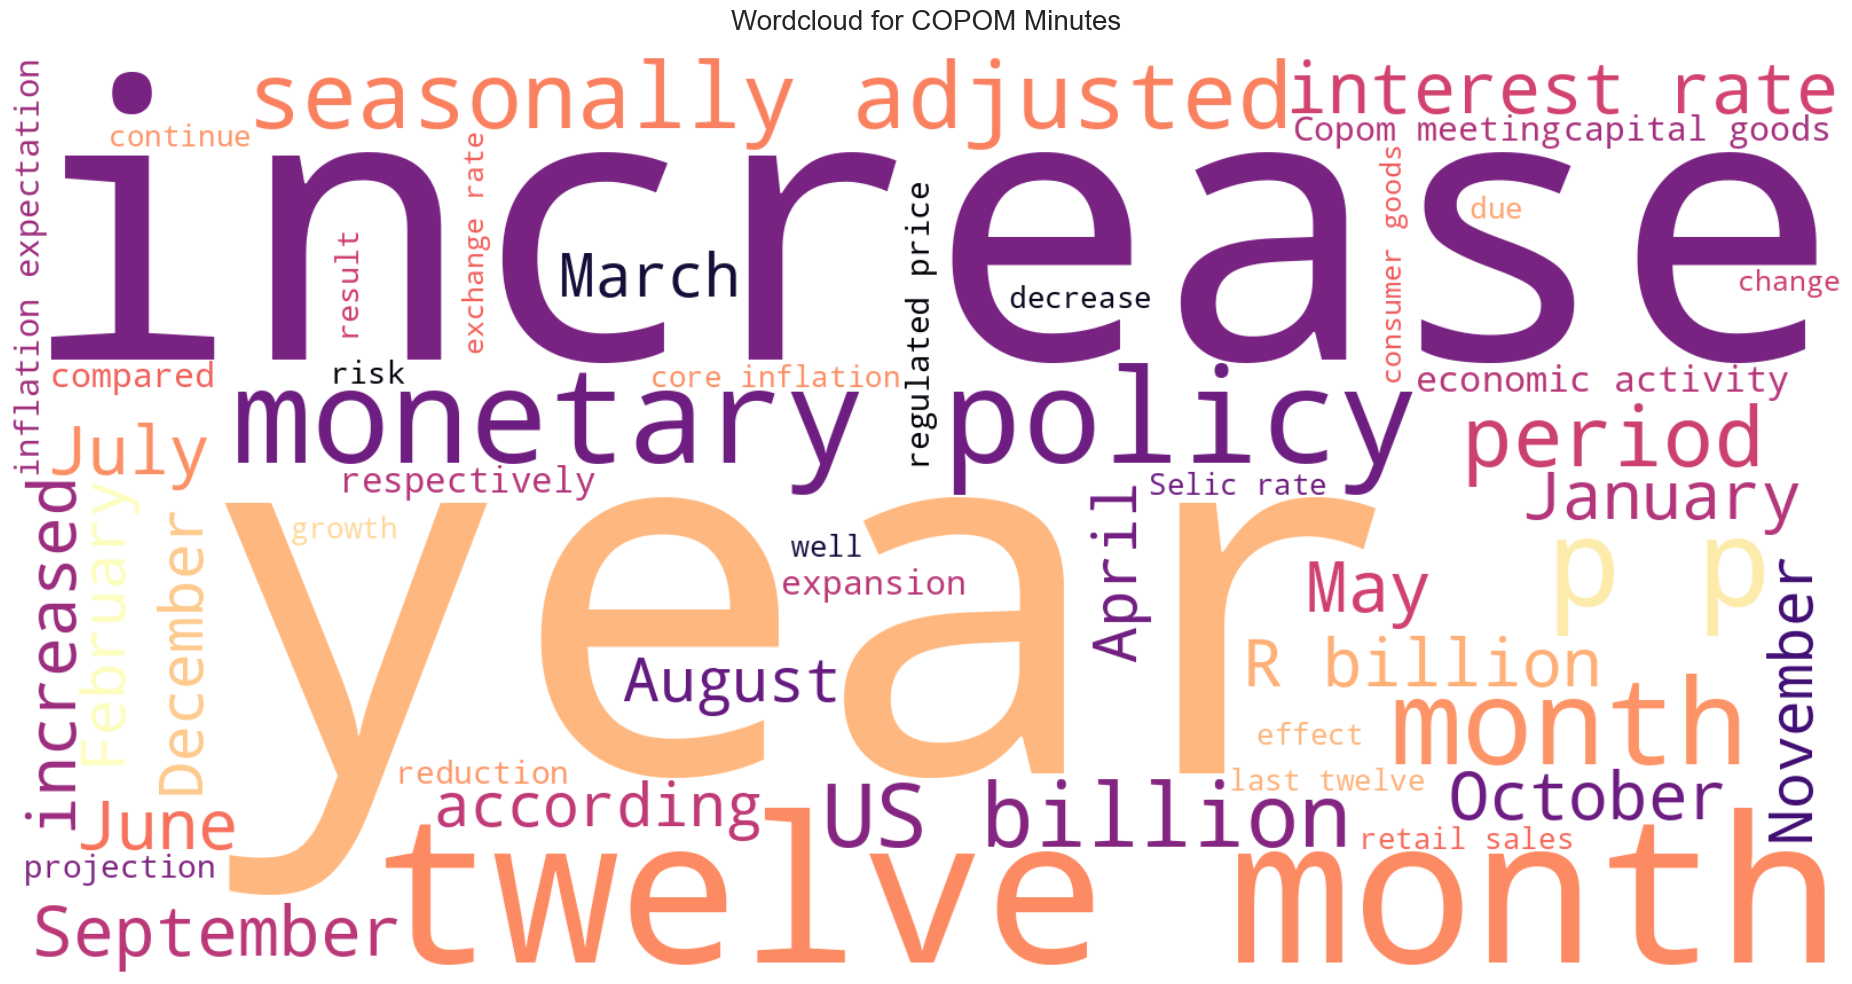

In [13]:
# 5° Graph: wordcloud
all_minutes_text = " ".join(full_corpus_text)
stopwords_set = set(stopwords.words('english'))

wordcloud = WordCloud(
    stopwords=stopwords_set, background_color="white", width=1600, height=800,
    max_words=50, colormap='magma'
).generate(all_minutes_text)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for COPOM Minutes', fontsize=20, pad=20)
plt.tight_layout()
plt.show()

plt.close()